<a href="https://colab.research.google.com/github/theill95/HFF/blob/main/Assignment3_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Read the data into a DataFrame
tweets_df = pd.read_csv('/content/drive/MyDrive/elonmusk.csv')

# Convert the 'Datetime' column to datetime format
tweets_df['Datetime'] = pd.to_datetime(tweets_df['Datetime'])

# Sort by ascending time
tweets_df = tweets_df.sort_values(by='Datetime')

tweets_df.tail()

,Datetime,Tweet Id,Text,Username
4,2023-06-28 18:05:58+00:00,1674116945808068608,@BillyM2k Best protip ever,elonmusk
3,2023-06-29 01:19:59+00:00,1674226170488057856,Improved longform posts,elonmusk
2,2023-06-29 03:46:37+00:00,1674263071337111552,@paulg Generational trauma. An example of why ...,elonmusk
1,2023-06-29 15:53:52+00:00,1674446089179766789,@TitterDaily True,elonmusk
0,2023-06-29 16:20:19+00:00,1674452749378002945,@mwseibel Yup,elonmusk


In [ ]:
import re

# Remove URLs, mentions, hashtags, and special characters from the 'Text' column
tweets_df['cleaned_text'] = tweets_df['Text'].apply(lambda x: re.sub(r'(https?://\S+)|(@\S+)|(#\S+)|[^a-zA-Z\s]', '', x))

# Convert text to lowercase
tweets_df['cleaned_text'] = tweets_df['cleaned_text'].str.lower()

tweets_df.tail()

,Datetime,Tweet Id,Text,Username,cleaned_text
4,2023-06-28 18:05:58+00:00,1674116945808068608,@BillyM2k Best protip ever,elonmusk,best protip ever
3,2023-06-29 01:19:59+00:00,1674226170488057856,Improved longform posts,elonmusk,improved longform posts
2,2023-06-29 03:46:37+00:00,1674263071337111552,@paulg Generational trauma. An example of why ...,elonmusk,generational trauma an example of why forgive...
1,2023-06-29 15:53:52+00:00,1674446089179766789,@TitterDaily True,elonmusk,true
0,2023-06-29 16:20:19+00:00,1674452749378002945,@mwseibel Yup,elonmusk,yup


In [ ]:
!pip install finvader


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [ ]:
from finvader import finvader

# Function to compute sentiment scores using FinVADER
def compute_finVADER_sentiment(text):
    return finvader(text, use_sentibignomics=True, use_henry=True, indicator='compound')

# Apply the function to your dataframe
tweets_df['finVADER_sentiment'] = tweets_df['Text'].apply(compute_finVADER_sentiment)

# Convert the compound scores to categorical labels for easier interpretation
tweets_df['finVADER_sentiment_label'] = tweets_df['finVADER_sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
tweets_df.describe()

,Tweet Id,finVADER_sentiment
count,2.445000e+04,24450.000000
mean,1.313594e+18,0.093856
std,3.304405e+17,0.261740
min,1.543473e+10,-0.969500
25%,1.120402e+18,0.000000
50%,1.390492e+18,0.004800
75%,1.596977e+18,0.263975
max,1.674453e+18,0.946600


In [ ]:
# Round up the time to the nearest hour
tweets_df['Hourly_Time'] = tweets_df['Datetime'].dt.ceil('H')

# Group by the rounded hour and aggregate the sentiment scores
hourly_sentiments = tweets_df.groupby('Hourly_Time')['finVADER_sentiment'].sum()

# Convert the aggregated sentiment scores to a dataframe
df = hourly_sentiments.reset_index()

# Assign a categorical label for the aggregated sentiment scores
df['finVADER_sentiment_label'] = df['finVADER_sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))

# Reduce the DateTime to only include year-month-date-time of day hh:mm:ss
df['Hourly_Time'] = df['Hourly_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

df.tail()

,Hourly_Time,finVADER_sentiment,finVADER_sentiment_label
10980,2023-06-28 19:00:00,0.3612,Positive
10981,2023-06-29 02:00:00,0.3612,Positive
10982,2023-06-29 04:00:00,-0.5071,Negative
10983,2023-06-29 16:00:00,0.4215,Positive
10984,2023-06-29 17:00:00,0.0000,Neutral


In [ ]:
# Create a full date range covering all hours between the minimum and maximum timestamps
full_date_range = pd.date_range(start=tweets_df['Datetime'].min().floor('H'),
                                end=tweets_df['Datetime'].max().ceil('H'),
                                freq='H')

full_date_df = pd.DataFrame({'Hourly_Time': full_date_range})

# Convert the 'Hourly_Time' column in full_date_df to string format to match the 'Hourly_Time' column in df
full_date_df['Hourly_Time'] = full_date_df['Hourly_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Merge with the aggregated sentiment scores
df = pd.merge(full_date_df, df, on='Hourly_Time', how='left')

# Fill any missing sentiment scores with 0 and label them as 'Neutral'
df['finVADER_sentiment'].fillna(0, inplace=True)
df['finVADER_sentiment_label'].fillna('Neutral', inplace=True)

# Rename columns
df.rename(columns={'Hourly_Time': 'time',
                   'finVADER_sentiment': 'sentiment',
                   'finVADER_sentiment_label': 'label'}, inplace=True)

df.tail()

,time,sentiment,label
114547,2023-06-29 13:00:00,0.0000,Neutral
114548,2023-06-29 14:00:00,0.0000,Neutral
114549,2023-06-29 15:00:00,0.0000,Neutral
114550,2023-06-29 16:00:00,0.4215,Positive
114551,2023-06-29 17:00:00,0.0000,Neutral


In [ ]:

# 1. Load the Bitcoin data
bitcoin_data = pd.read_csv('/content/drive/MyDrive/BTCUSD_1h.csv')

# 2. Convert 'Timestamp' column to the appropriate datetime format
bitcoin_data['Timestamp'] = pd.to_datetime(bitcoin_data['Timestamp'], dayfirst=True)
bitcoin_data['Timestamp'] = bitcoin_data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Create 'midprice' column
bitcoin_data['midprice'] = (bitcoin_data['Ask'] + bitcoin_data['Bid']) / 2

# Drop the 'Ask', 'Bid', and 'Volume' columns
bitcoin_data = bitcoin_data[['Timestamp', 'midprice']]

# 3. Merge with the sentiment dataframe on timestamps
merged_df = pd.merge(df, bitcoin_data, left_on='time', right_on='Timestamp', how='left')
merged_df.drop(columns=['Timestamp'], inplace=True)

# Drop observations before 2017-07-09
merged_df = merged_df[merged_df['time'] >= '2017-07-09']


merged_df.tail(50)

,time,sentiment,label,midprice
74392,2023-06-27 16:00:00,0.0000,Neutral,30507.84
74393,2023-06-27 17:00:00,0.0782,Positive,30720.31
74394,2023-06-27 18:00:00,0.0000,Neutral,30741.31
74395,2023-06-27 19:00:00,0.0000,Neutral,30696.82
74396,2023-06-27 20:00:00,0.0000,Neutral,30662.04
74397,2023-06-27 21:00:00,0.0000,Neutral,30658.77
74398,2023-06-27 22:00:00,0.0000,Neutral,30726.20
74399,2023-06-27 23:00:00,0.0000,Neutral,30594.88
74400,2023-06-28 00:00:00,0.1314,Positive,30700.30
74401,2023-06-28 01:00:00,0.0931,Positive,30619.51


In [ ]:
import matplotlib.pyplot as plt

# Setting up the figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting Bitcoin prices on the primary y-axis
ax1.plot(merged_df['time'], merged_df['midprice'], color='b', label='Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Bitcoin Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a secondary y-axis for sentiment scores
ax2 = ax1.twinx()
ax2.plot(merged_df['time'], merged_df['sentiment'], color='r', label='Sentiment Score')
ax2.set_ylabel('Sentiment Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Setting the title and showing the plot
plt.title('Bitcoin Prices and Sentiment Scores Over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Calculate hourly returns
merged_df['returns'] = merged_df['midprice'].pct_change()

# Lagged features for sentiment scores
for i in range(1, 5):  # Generate up to 4 lags as an example
    merged_df[f'sentiment_lag_{i}'] = merged_df['sentiment'].shift(i)

# Lagged features for returns
for i in range(1, 5):
    merged_df[f'return_lag_{i}'] = merged_df['returns'].shift(i)

merged_df['signal'] = np.where(merged_df['sentiment'] > 0, 1,  # Buy
                              np.where(merged_df['sentiment'] < 0, -1,  # Sell
                                       0))  # Neutral, when sentiment = 0

merged_df['ma_sentiment_3'] = merged_df['sentiment'].rolling(window=3).mean()
merged_df['ma_sentiment_12'] = merged_df['sentiment'].rolling(window=12).mean()
merged_df['ma_sentiment_24'] = merged_df['sentiment'].rolling(window=24).mean()
merged_df['ma_signal'] = np.where(merged_df['ma_sentiment_3'] > merged_df['ma_sentiment_24'], 1, -1)

threshold = 0.1
merged_df['strength_signal'] = np.where((merged_df['ma_sentiment_3'] > threshold) &
                                        (merged_df['ma_sentiment_12'] > threshold) &
                                        (merged_df['ma_sentiment_24'] > threshold), 1,
                                       np.where((merged_df['ma_sentiment_3'] < -threshold) &
                                                (merged_df['ma_sentiment_12'] < -threshold) &
                                                (merged_df['ma_sentiment_24'] < -threshold), -1, 0))


In [ ]:
merged_df.describe()

In [ ]:
merged_df.drop('label', axis=1, inplace=True)
train_size = int(len(merged_df) * 0.6)
val_size = int(len(merged_df) * 0.2)

train = merged_df.iloc[:train_size]
validation = merged_df.iloc[train_size:train_size+val_size]
test = merged_df.iloc[train_size+val_size:]

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Preprocessing
# Remove NA values since models can't handle them. NAs could arise from pct_change() and rolling calculations.
train = train.dropna()

# Define features and target
X_train = train.drop(columns=['returns'])
y_train = train['returns']

# Use GridSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model for predictions or further analysis
best_rf = grid_search.best_estimator_

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
            Feature  Importance
5      return_lag_1    0.351285
7      return_lag_3    0.199637
6      return_lag_2    0.189149
8      return_lag_4    0.149309
12  ma_sentiment_24    0.042572
3   sentiment_lag_3    0.019116
11  ma_sentiment_12    0.014473
4   sentiment_lag_4    0.009914
2   sentiment_lag_2    0.005340
0         sentiment    0.005050
10   ma_sentiment_3    0.004539
1   sentiment_lag_1    0.003893
9            signal    0.003311
13        ma_signal    0.002277
14  strength_signal    0.000135


In [ ]:
import joblib

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Save the model to a file
joblib.dump(best_rf, 'random_forest_model.pkl')

# If you want to load the model in the future:
# best_rf = joblib.load('random_forest_model.pkl')

# Evaluate model's performance on the validation set
X_val = validation.drop(columns=['returns'])
y_val = validation['returns']

y_pred = best_rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 0.005499127693189195
Mean Squared Error: 6.788535997160068e-05
R-squared: 0.0007181317555152722


In [ ]:
# Ensure non-numeric columns, if any, are removed and fill NA values
X_validation = validation.drop(columns=['returns']).select_dtypes(include=[np.number]).fillna(0)

# Get predictions using the best RandomForest model
# validation['prediction'] = best_rf.predict(X_validation)

validation.describe()

,sentiment,returns,sentiment_lag_1,sentiment_lag_2,sentiment_lag_3,sentiment_lag_4,return_lag_1,return_lag_2,return_lag_3,return_lag_4,signal,ma_sentiment_3,ma_sentiment_12,ma_sentiment_24,ma_signal,strength_signal,prediction
count,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000,10472.000000
mean,0.033959,0.000038,0.033959,0.034011,0.034011,0.034011,0.000036,0.000036,0.000036,0.000035,0.080787,0.033976,0.033997,0.033963,-0.433155,0.019576,0.000093
std,0.181902,0.008243,0.181902,0.181971,0.181971,0.181971,0.008247,0.008247,0.008247,0.008247,0.360876,0.110276,0.057474,0.041324,0.901362,0.138545,0.000708
min,-1.157200,-0.109427,-1.157200,-1.157200,-1.157200,-1.157200,-0.109427,-0.109427,-0.109427,-0.109427,-1.000000,-0.401400,-0.142242,-0.069071,-1.000000,0.000000,-0.020082
25%,0.000000,-0.003651,0.000000,0.000000,0.000000,0.000000,-0.003652,-0.003652,-0.003651,-0.003651,0.000000,0.000000,0.000000,0.001383,-1.000000,0.000000,0.000063
50%,0.000000,0.000077,0.000000,0.000000,0.000000,0.000000,0.000077,0.000077,0.000077,0.000075,0.000000,0.000000,0.009767,0.024521,-1.000000,0.000000,0.000088
75%,0.000000,0.003834,0.000000,0.000000,0.000000,0.000000,0.003834,0.003834,0.003834,0.003833,0.000000,0.001300,0.056542,0.054529,1.000000,0.000000,0.000088
max,2.764700,0.093376,2.764700,2.764700,2.764700,2.764700,0.093376,0.093376,0.093376,0.093376,1.000000,1.234967,0.406133,0.261163,1.000000,1.000000,0.023857


In [ ]:
!pip install bayesian-optimization

In [ ]:
validation.tail()



,sentiment,returns,sentiment_lag_1,sentiment_lag_2,sentiment_lag_3,sentiment_lag_4,return_lag_1,return_lag_2,return_lag_3,return_lag_4,signal,ma_sentiment_3,ma_sentiment_12,ma_sentiment_24,ma_signal,strength_signal,prediction
time,,,,,,,,,,,,,,,,,
2022-04-19 04:00:00,0.0,0.002322,0.0,0.0,0.0,0.0,-0.003516,-0.003374,0.002033,-0.002742,0,0.0,0.0549,0.080888,-1,0,0.000088
2022-04-19 05:00:00,0.0,0.003850,0.0,0.0,0.0,0.0,0.002322,-0.003516,-0.003374,0.002033,0,0.0,0.0549,0.080888,-1,0,0.000088
2022-04-19 06:00:00,0.0,-0.004845,0.0,0.0,0.0,0.0,0.003850,0.002322,-0.003516,-0.003374,0,0.0,0.0549,0.080888,-1,0,0.000088
2022-04-19 07:00:00,0.0,0.001163,0.0,0.0,0.0,0.0,-0.004845,0.003850,0.002322,-0.003516,0,0.0,0.0549,0.080888,-1,0,0.000088
2022-04-19 08:00:00,0.0,-0.000516,0.0,0.0,0.0,0.0,0.001163,-0.004845,0.003850,0.002322,0,0.0,0.0549,0.080888,-1,0,0.000088


In [ ]:
bitcoin_data.tail()

,Timestamp,midprice
48129,2023-06-30 19:00:00,30366.83
48130,2023-06-30 20:00:00,30380.04
48131,2023-06-30 21:00:00,30405.67
48132,2023-06-30 22:00:00,30477.92
48133,2023-06-30 23:00:00,30481.96


In [ ]:
# Convert both time columns to datetime type if they aren't already
validation.index = pd.to_datetime(validation.index)
bitcoin_data['Timestamp'] = pd.to_datetime(bitcoin_data['Timestamp'])

# Merge with the bitcoin_data DataFrame on timestamps to get the midprice for the validation dataset
validation = pd.merge(validation, bitcoin_data[['Timestamp', 'midprice']], left_on=validation.index, right_on='Timestamp', how='left').set_index('Timestamp')
validation.drop(columns=['Timestamp'], inplace=True, errors='ignore')  # Drop extra column if it exists


In [ ]:
validation.tail()

,sentiment,returns,sentiment_lag_1,sentiment_lag_2,sentiment_lag_3,sentiment_lag_4,return_lag_1,return_lag_2,return_lag_3,return_lag_4,signal,ma_sentiment_3,ma_sentiment_12,ma_sentiment_24,ma_signal,strength_signal,prediction,midprice
Timestamp,,,,,,,,,,,,,,,,,,
2022-04-19 04:00:00,0.0,0.002322,0.0,0.0,0.0,0.0,-0.003516,-0.003374,0.002033,-0.002742,0,0.0,0.0549,0.080888,-1,0,0.000088,40697.69
2022-04-19 05:00:00,0.0,0.003850,0.0,0.0,0.0,0.0,0.002322,-0.003516,-0.003374,0.002033,0,0.0,0.0549,0.080888,-1,0,0.000088,40854.37
2022-04-19 06:00:00,0.0,-0.004845,0.0,0.0,0.0,0.0,0.003850,0.002322,-0.003516,-0.003374,0,0.0,0.0549,0.080888,-1,0,0.000088,40656.42
2022-04-19 07:00:00,0.0,0.001163,0.0,0.0,0.0,0.0,-0.004845,0.003850,0.002322,-0.003516,0,0.0,0.0549,0.080888,-1,0,0.000088,40703.69
2022-04-19 08:00:00,0.0,-0.000516,0.0,0.0,0.0,0.0,0.001163,-0.004845,0.003850,0.002322,0,0.0,0.0549,0.080888,-1,0,0.000088,40682.70


In [ ]:
from bayes_opt import BayesianOptimization



def trading_strategy(threshold_upper, threshold_lower, take_profit, stop_loss):
    position = 0  # 1 for 'long' (buy), -1 for 'short' (sell), 0 for no position
    profit = 0
    initial_price = 0  # To calculate profit or loss for a trade

    for idx, row in validation.iterrows():
        current_return = row['prediction']
        if position == 0:
            if current_return > threshold_upper:
                position = 1
                initial_price = row['midprice']
            elif current_return < threshold_lower:
                position = -1
                initial_price = row['midprice']
        elif position == 1:  # Long position
            # Calculate current profit or loss
            current_profit = (row['midprice'] - initial_price) / initial_price
            if current_profit >= take_profit or current_profit <= -stop_loss:
                profit += current_profit
                position = 0
        elif position == -1:  # Short position
            # Calculate current profit or loss
            current_profit = (initial_price - row['midprice']) / initial_price
            if current_profit >= take_profit or current_profit <= -stop_loss:
                profit += current_profit
                position = 0

    return -profit  # negative because we want to maximize profit


# Define the bounds for the parameters
pbounds = {
    'threshold_upper': (0, 0.05),
    'threshold_lower': (-0.05, 0),
    'take_profit': (0.001, 1),   # you can adjust these bounds according to what's reasonable
    'stop_loss': (0.001, 1)
}

optimizer = BayesianOptimization(
    f=trading_strategy,
    pbounds=pbounds,
    random_state=47,
)

# Optimization (can adjust the number of steps and init_points based on your needs)
optimizer.maximize(
    init_points=30,
    n_iter=150,
)

print(optimizer.max)


|   iter    |  target   | stop_loss | take_p... | thresh... | thresh... |
-------------------------------------------------------------------------
| 1         | 0.4834    | 0.1144    | 0.9745    | -0.01356  | 0.01757   |
| 2         | 0.0       | 0.7079    | 0.7998    | -0.01772  | 0.02073   |
| 3         | -0.5054   | 0.7063    | 0.2474    | -0.0372   | 0.001201  |
| 4         | 0.1203    | 0.09963   | 0.3011    | -0.01796  | 0.01611   |
| 5         | 0.1892    | 0.1863    | 0.9173    | -0.03645  | 0.01368   |
| 6         | -0.4059   | 0.9545    | 0.128     | -0.01264  | 0.0002619 |
| 7         | 0.0       | 0.8569    | 0.6963    | -0.02235  | 0.04676   |
| 8         | -0.19     | 0.5131    | 0.1784    | -0.02316  | 0.01467   |
| 9         | 0.01593   | 0.01159   | 0.8839    | -0.01718  | 0.04711   |
| 10        | 0.0       | 0.7452    | 0.2679    | -0.03191  | 0.02632   |
| 11        | -0.2602   | 0.5473    | 0.2594    | -0.04127  | 0.01804   |
| 12        | 0.0       | 0.141     | 

In [ ]:
def trading_strategy(threshold_upper, threshold_lower, take_profit, stop_loss):
    position = 0  # 1 for 'long' (buy), -1 for 'short' (sell), 0 for no position
    profit = 0
    trades = []
    for idx, row in validation.iterrows():
        if row['prediction'] > threshold_upper and position <= 0:  # Open/Reverse to Buy position
            if position == -1:
                trades.append(profit)  # Close sell position
            position = 1
            entry_price = row['midprice']

        elif row['prediction'] < threshold_lower and position >= 0:  # Open/Reverse to Sell position
            if position == 1:
                trades.append(profit)  # Close buy position
            position = -1
            entry_price = row['midprice']

        # Calculate profit for open position
        if position == 1:  # Long
            profit = row['midprice'] - entry_price
        elif position == -1:  # Short
            profit = entry_price - row['midprice']

        # Take profit or stop loss
        if profit > take_profit or profit < -stop_loss:
            trades.append(profit)
            profit = 0
            position = 0

    return trades

optimized_parameters = {'stop_loss': 0.7084421820019063, 'take_profit': 0.8973689324904034, 'threshold_lower': -0.00026088459386275353, 'threshold_upper': 0.03346571917952352}
trades = trading_strategy(**optimized_parameters)

for idx, trade_profit in enumerate(trades):
    print(f"Trade {idx + 1}: Profit/Loss = {trade_profit}")




Trade 1: Profit/Loss = 93.20999999999913
Trade 2: Profit/Loss = -109.15000000000873
Trade 3: Profit/Loss = 125.16000000000349
Trade 4: Profit/Loss = 605.8300000000017
Trade 5: Profit/Loss = -264.63000000000466
Trade 6: Profit/Loss = -777.7200000000012
Trade 7: Profit/Loss = -378.1200000000099
Trade 8: Profit/Loss = -29.170000000012806
Trade 9: Profit/Loss = 111.30999999999767
Trade 10: Profit/Loss = -121.22000000000116
Trade 11: Profit/Loss = 1119.590000000011
Trade 12: Profit/Loss = 1746.75
Trade 13: Profit/Loss = 1260.0299999999988
Trade 14: Profit/Loss = 313.6900000000023
Trade 15: Profit/Loss = -2349.149999999994
Trade 16: Profit/Loss = -1678.3799999999974
Trade 17: Profit/Loss = 137.86999999999534
Trade 18: Profit/Loss = 1123.3800000000047
Trade 19: Profit/Loss = 331.66999999999825
Trade 20: Profit/Loss = -284.7199999999939
Trade 21: Profit/Loss = 386.25
Trade 22: Profit/Loss = -144.38999999999942
Trade 23: Profit/Loss = 270.3700000000099
Trade 24: Profit/Loss = -287.8800000000046

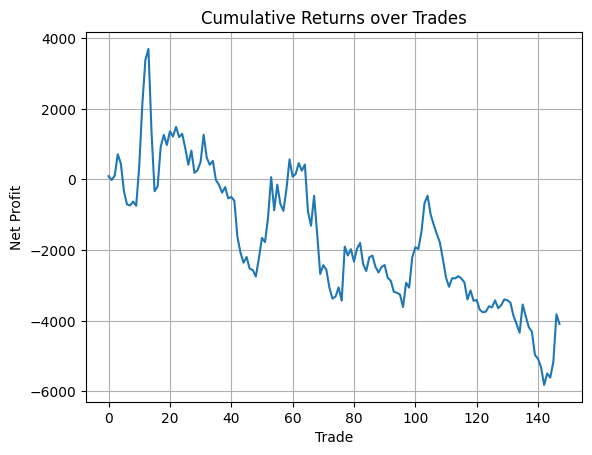

In [ ]:
import matplotlib.pyplot as plt

cumulative_returns = [sum(trades[:i+1]) for i in range(len(trades))]

# Plotting
plt.plot(cumulative_returns)
plt.xlabel('Trade')      # X-axis label
plt.ylabel('Net Profit') # Y-axis label
plt.title('Cumulative Returns over Trades') # Title of the plot
plt.grid(True)           # Show gridlines for clarity
plt.show()

In [ ]:
initial_balance = 10000
Net_profit = sum(trades)

# Compute daily returns for Sharpe Ratio
daily_returns = [trade / initial_balance for trade in trades]
sharpe_ratio = (252**0.5) * (sum(daily_returns) / len(daily_returns)) / (sum([(i - sum(daily_returns) / len(daily_returns))**2 for i in daily_returns]) / len(daily_returns))**0.5

# Hit Ratio
winning_trades = len([profit for profit in trades if profit > 0])
hit_ratio = (winning_trades / len(trades)) * 100

# Number of Trades
number_of_trades = len(trades)

# Max Equity Drawdown
cumulative_profits = [initial_balance + sum(trades[:i+1]) for i in range(len(trades))]
max_equity = max(cumulative_profits)
peak_idx = cumulative_profits.index(max_equity)
max_drawdown = min(cumulative_profits[peak_idx:]) - max_equity
max_equity_drawdown = (max_drawdown / max_equity) * 100

print(f"Net Profit: ${Net_profit:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Hit Ratio: {hit_ratio:.2f}%")
print(f"Number of Trades: {number_of_trades}")
print(f"Max Equity Drawdown: {max_equity_drawdown:.2f}%")


Net Profit: $-4087.92
Sharpe Ratio: -0.80
Hit Ratio: 42.57%
Number of Trades: 148
Max Equity Drawdown: -69.44%
